# Análisis Espacial de Puntos de Interés de Salud en Cochabamba

Este notebook realiza un análisis espacial de la distribución de servicios de salud (hospitales, clínicas, farmacias) en el departamento de Cochabamba, Bolivia. 

## Objetivos:
- Obtener datos de puntos de interés (POI) de salud desde OpenStreetMap usando OSMnx
- Descargar límites municipales desde servicios web geoespaciales (WFS)
- Realizar análisis espacial para calcular densidad de servicios por municipio
- Visualizar los resultados mediante mapas coropléticos

## Metodología:
1. **Extracción de datos**: Uso de OSMnx para obtener POI de salud y servicios WFS para límites administrativos
2. **Análisis espacial**: Join espacial entre puntos y polígonos, cálculo de densidades
3. **Visualización**: Mapas coropléticos combinando datos vectoriales y puntuales

## 1. Instalación de Dependencias

Instalamos las librerías necesarias para el análisis geoespacial:
- **geopandas**: Manejo de datos geoespaciales
- **osmnx**: Interfaz para OpenStreetMap y cálculo de rutas
- **matplotlib**: Visualizaciones
- **pyproj, shapely**: Proyecciones cartográficas y geometrías
- **requests**: Peticiones HTTP para servicios web
- **owslib**: Cliente para servicios OGC (WMS, WFS)

In [1]:
%pip install geopandas pyproj shapely requests osmnx owslib matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/338.4 kB ? eta -:--:--Downloading geopandas-1.1.1-py3-none-any.whl (338 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/4.6 MB ? eta -:--:--Downloading pyproj-3.7.2-cp311-cp311-macosx_14_0_arm64.whl (4.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 6.6 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 6.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 19.7 MB/s eta 0

## 2. Importación de Librerías

Importamos las librerías necesarias y configuramos OSMnx para optimizar el rendimiento:

In [2]:
# Importaciones principales
import geopandas as gpd  # Para trabajar con datos geoespaciales
import pandas as pd      # Análisis de datos
import requests          # Peticiones HTTP
import os               # Operaciones del sistema
import matplotlib.pyplot as plt  # Visualizaciones

# OSMnx para datos de OpenStreetMap
import osmnx as ox
ox.settings.use_cache = True     # Cachear resultados para mejorar rendimiento
ox.settings.log_console = False  # Reducir verbosidad en consola

## 3. Obtención de Puntos de Interés de Salud desde OpenStreetMap

Utilizamos OSMnx para obtener puntos de interés relacionados con servicios de salud. Esto incluye hospitales, clínicas, consultorios médicos y farmacias dentro del área de estudio definida.

In [3]:
# Definir área de estudio
AREA = "Departamento de Cochabamba, Bolivia"  # Cambiar a "Cochabamba, Bolivia" para solo el municipio

# Obtener el polígono del área de estudio por nombre
print(f"Obteniendo límites geográficos de: {AREA}")
gdf_area = ox.geocode_to_gdf(AREA)  # Obtiene el boundary del lugar desde OSM
gdf_area = gdf_area.to_crs(4326)    # Asegurar CRS WGS84

# Definir los tipos de servicios de salud a buscar
tags_salud = {
    "amenity": ["hospital", "clinic", "doctors", "pharmacy"]
}

# Descargar amenities de salud usando la API Overpass a través de OSMnx
print("Descargando puntos de interés de salud...")
pois = ox.features_from_polygon(gdf_area.geometry.iloc[0], tags_salud)

# Limpiar datos: mantener solo columnas relevantes y resetear índice
pois = pois.to_crs(4326)[["name", "amenity", "geometry"]].reset_index(drop=True)

print(f"Total de POIs encontrados: {len(pois)}")
print("\nPrimeros registros:")
pois.head(3)

Obteniendo límites geográficos de: Departamento de Cochabamba, Bolivia
Descargando puntos de interés de salud...
Descargando puntos de interés de salud...


/opt/homebrew/lib/python3.11/site-packages/osmnx/_overpass.py:271: UserWarning: This area is 32 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


Total de POIs encontrados: 749

Primeros registros:


,name,amenity,geometry
0,Farmacia Boliviana,pharmacy,POINT (-66.15725 -17.39446)
1,Centro de Salud San Juan de Dios,clinic,POINT (-66.81983 -17.08474)
2,NaN,pharmacy,POINT (-65.19084 -17.73531)


## 4. Carga de Límites Municipales desde Archivo Local

Utilizamos un archivo GeoJSON local con los límites municipales de Bolivia para evitar dependencias de servicios web externos.

In [9]:
# Cargar límites municipales desde archivo GeoJSON local
print("Cargando límites municipales desde archivo local...")
muni_path = "data/Bolivia-Municipalities.geojson"
muni = gpd.read_file(muni_path)

# Asegurar que está en WGS84
muni = muni.to_crs(4326)

print(f"✓ Datos municipales cargados exitosamente: {len(muni)} municipios")
print(f"Columnas disponibles: {list(muni.columns)}")

# Mostrar muestra de los datos
muni.head()

Cargando límites municipales desde archivo local...
✓ Datos municipales cargados exitosamente: 339 municipios
Columnas disponibles: ['Municipality', 'ADM3_PCODE', 'Province', 'Department', 'ADM0_ES', 'area_ha', 'geometry']


,Municipality,ADM3_PCODE,Province,Department,ADM0_ES,area_ha,geometry
0,Acasio,BO051302,General Bilbao,Potosí,Bolivia (Estado Plurinacional de),37515,"POLYGON ((-65.99143 -17.92303, -65.99763 -17.9..."
1,Achacachi,BO020201,Omasuyos,La Paz,Bolivia (Estado Plurinacional de),74708,"POLYGON ((-68.69445 -15.85508, -68.70378 -15.8..."
2,Achocalla,BO020104,Murillo,La Paz,Bolivia (Estado Plurinacional de),17800,"POLYGON ((-68.15337 -16.54096, -68.16053 -16.5..."
3,Aiquile,BO030201,Campero,Cochabamba,Bolivia (Estado Plurinacional de),268525,"POLYGON ((-65.19602 -17.93627, -65.19918 -17.9..."
4,Alalay,BO031303,Mizque,Cochabamba,Bolivia (Estado Plurinacional de),41905,"POLYGON ((-65.5521 -17.70838, -65.57771 -17.69..."


## 5. Análisis Espacial: Intersección y Cálculo de Densidades

En esta sección realizamos:
1. **Clip espacial**: Recortamos los municipios al área de estudio
2. **Join espacial**: Asignamos cada POI al municipio correspondiente
3. **Cálculo de métricas**: Conteo de POIs por municipio y densidad por área

In [10]:
# 1. Filtrar municipios del departamento de Cochabamba
print("Filtrando municipios del departamento de Cochabamba...")
muni_cochabamba = muni[muni['Department'] == 'Cochabamba'].copy()
print(f"Municipios de Cochabamba encontrados: {len(muni_cochabamba)}")

# 2. Clip de municipios al área de estudio
print("Realizando intersección espacial entre municipios y área de estudio...")
muni_clip = gpd.overlay(muni_cochabamba, gdf_area[["geometry"]], how="intersection")

# 3. Asegurar geometrías válidas (corregir posibles errores topológicos)
muni_clip["geometry"] = muni_clip["geometry"].buffer(0)
print(f"Municipios después del clip: {len(muni_clip)}")

# 4. Join espacial: asignar municipio a cada POI
print("Realizando join espacial entre POIs y municipios...")
pois_in = gpd.sjoin(pois, muni_clip, predicate="within", how="inner")
print(f"POIs dentro de municipios: {len(pois_in)} de {len(pois)} total")

# 5. Conteo de POIs por municipio
print("\nCalculando estadísticas por municipio...")
res = (pois_in.groupby("Municipality")  # Usar el nombre correcto de la columna
       .size()
       .reset_index(name="n_pois"))

# 6. Merge con datos municipales
muni_stats = muni_clip.merge(res, on="Municipality", how="left").fillna({"n_pois": 0})

# 7. Calcular área en km² (usando proyección métrica)
muni_stats = muni_stats.to_crs(3857)  # Web Mercator para cálculos de área
muni_stats["area_km2"] = muni_stats.geometry.area / 1e6

# 8. Calcular densidad (POIs por 100 km²)
muni_stats["pois_por_100km2"] = 100 * muni_stats["n_pois"] / muni_stats["area_km2"]

# Volver a WGS84 para visualización
muni_stats = muni_stats.to_crs(4326)

# 9. Mostrar resultados ordenados por número de POIs
resultado = muni_stats[["Municipality", "n_pois", "area_km2", "pois_por_100km2"]].sort_values("n_pois", ascending=False)
print("\nRanking de municipios por número de servicios de salud:")
resultado

Filtrando municipios del departamento de Cochabamba...
Municipios de Cochabamba encontrados: 47
Realizando intersección espacial entre municipios y área de estudio...
Municipios después del clip: 47
Realizando join espacial entre POIs y municipios...
POIs dentro de municipios: 749 de 749 total

Calculando estadísticas por municipio...

Ranking de municipios por número de servicios de salud:


,Municipality,n_pois,area_km2,pois_por_100km2
12,Cochabamba,503.0,317.719331,158.315831
25,Sacaba,34.0,828.763346,4.102498
36,Tiquipaya,29.0,348.880738,8.312296
24,Quillacollo,21.0,625.529538,3.357156
45,Villa Tunari,18.0,12110.642688,0.148630
0,Aiquile,12.0,2992.969464,0.400940
40,Totora,12.0,2363.229587,0.507780
16,Mizque,10.0,2088.666545,0.478774
13,Colcapirhua,9.0,31.999879,28.125106
10,Cliza,8.0,61.802192,12.944525


## 6. Visualización: Mapas Coropléticos Comparativos

Creamos dos mapas coropléticos para comparar enfoques de visualización:
- **Mapa por categorías**: Clasificación que resalta mejor las diferencias entre municipios
- **Mapa continuo**: Escala original que muestra el rango completo de valores

El mapa por categorías es más informativo para análisis territorial y toma de decisiones.

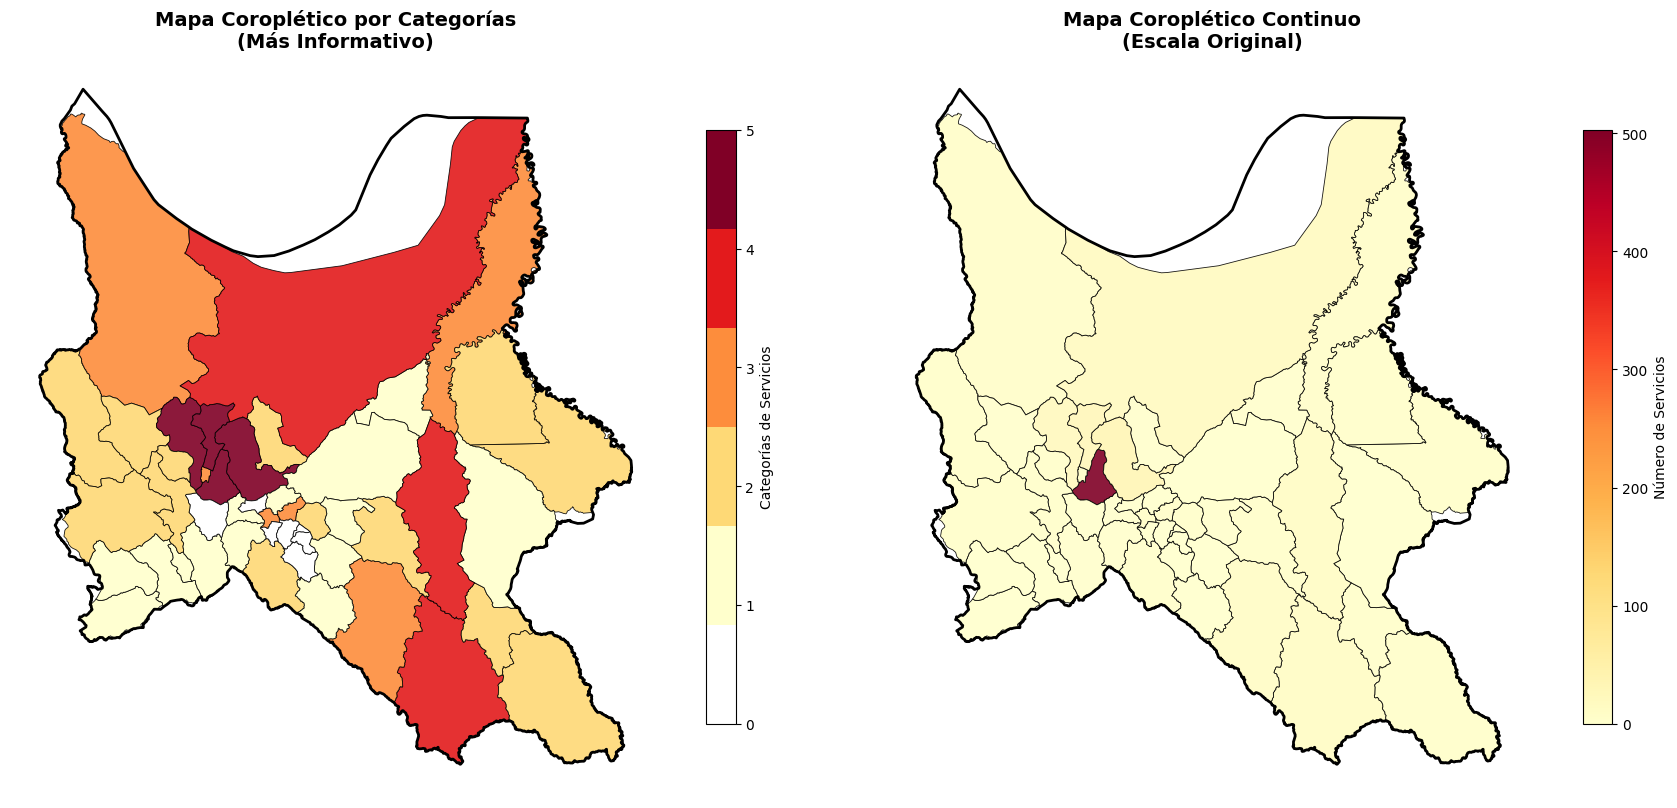


INTERPRETACIÓN DE CATEGORÍAS
0 (Blanco): Sin servicios (7 municipios)
1 (Amarillo muy claro): 1-2 servicios (12 municipios)
2 (Amarillo claro): 3-5 servicios (15 municipios)
3 (Naranja claro): 6-10 servicios (6 municipios)
4 (Naranja oscuro): 11-20 servicios (3 municipios)
5 (Rojo oscuro): 20+ servicios (4 municipios)


In [17]:
# Crear un mapa coroplético más informativo usando clasificación por cuantiles
import numpy as np
import matplotlib.colors as colors

# Crear clasificación manual para mejor visualización
def clasificar_servicios(n_servicios):
    if n_servicios == 0:
        return 0
    elif n_servicios <= 2:
        return 1
    elif n_servicios <= 5:
        return 2
    elif n_servicios <= 10:
        return 3
    elif n_servicios <= 20:
        return 4
    else:
        return 5

# Aplicar clasificación
muni_stats['categoria'] = muni_stats['n_pois'].apply(clasificar_servicios)

# Crear figura mejorada
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Mapa 1: Clasificación por categorías (más informativo)
colores_categorias = ['white', '#ffffcc', '#fed976', '#fd8d3c', '#e31a1c', '#800026']
cmap_categorias = colors.ListedColormap(colores_categorias)

muni_stats.plot(
    column="categoria", 
    ax=ax1, 
    legend=True, 
    edgecolor="black", 
    linewidth=0.6,
    cmap=cmap_categorias,
    alpha=0.9,
    legend_kwds={
        'label': "Categorías de Servicios",
        'shrink': 0.8
    }
)

# Límite departamental
gdf_area.boundary.plot(ax=ax1, color="black", linewidth=2)

ax1.set_title("Mapa Coroplético por Categorías\n(Más Informativo)", fontsize=14, fontweight='bold')
ax1.set_axis_off()

# Mapa 2: Escala continua original (para comparación)
muni_stats.plot(
    column="n_pois", 
    ax=ax2, 
    legend=True, 
    edgecolor="black", 
    linewidth=0.6,
    cmap="YlOrRd",
    alpha=0.9,
    legend_kwds={
        'label': "Número de Servicios",
        'shrink': 0.8
    }
)

gdf_area.boundary.plot(ax=ax2, color="black", linewidth=2)

ax2.set_title("Mapa Coroplético Continuo\n(Escala Original)", fontsize=14, fontweight='bold')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

# Leyenda de categorías
print("\n" + "="*60)
print("INTERPRETACIÓN DE CATEGORÍAS")
print("="*60)
print("0 (Blanco): Sin servicios (7 municipios)")
print("1 (Amarillo muy claro): 1-2 servicios (12 municipios)") 
print("2 (Amarillo claro): 3-5 servicios (15 municipios)")
print("3 (Naranja claro): 6-10 servicios (6 municipios)")
print("4 (Naranja oscuro): 11-20 servicios (3 municipios)")
print("5 (Rojo oscuro): 20+ servicios (4 municipios)")
print("="*60)

## 7. Análisis Estadístico Complementario

Estadísticas detalladas para complementar la interpretación de los mapas coropléticos:

In [18]:
# Estadísticas principales del análisis
print("="*60)
print("ESTADÍSTICAS CLAVE DEL ANÁLISIS")
print("="*60)

print(f"Total de servicios de salud encontrados: {len(pois)}")
print(f"Total de municipios analizados: {len(muni_stats)}")
print(f"Municipios con servicios: {len(muni_stats[muni_stats['n_pois'] > 0])}")

# Top 10 municipios por servicios
print(f"\nTop 10 municipios por número de servicios:")
top_10 = muni_stats.nlargest(10, 'n_pois')[['Municipality', 'n_pois']]
for i, (_, row) in enumerate(top_10.iterrows(), 1):
    pct = (row['n_pois'] / muni_stats['n_pois'].sum() * 100)
    print(f"{i:2d}. {row['Municipality']}: {int(row['n_pois'])} servicios ({pct:.1f}%)")

# Distribución por tipo de servicio
print(f"\nDistribución por tipo de servicio:")
tipo_counts = pois_in['amenity'].value_counts()
for tipo, cantidad in tipo_counts.items():
    pct = (cantidad / len(pois_in) * 100)
    print(f"  • {tipo.capitalize()}: {cantidad} ({pct:.1f}%)")

# Análisis de densidad
print(f"\nAnálisis de densidad espacial:")
print(f"  • Densidad promedio: {muni_stats['pois_por_100km2'].mean():.1f} POIs/100km²")
max_density_idx = muni_stats['pois_por_100km2'].idxmax()
print(f"  • Densidad máxima: {muni_stats['pois_por_100km2'].max():.1f} POIs/100km² ({muni_stats.loc[max_density_idx, 'Municipality']})")

print("="*60)

ESTADÍSTICAS CLAVE DEL ANÁLISIS
Total de servicios de salud encontrados: 749
Total de municipios analizados: 47
Municipios con servicios: 40

Top 10 municipios por número de servicios:
 1. Cochabamba: 503 servicios (67.2%)
 2. Sacaba: 34 servicios (4.5%)
 3. Tiquipaya: 29 servicios (3.9%)
 4. Quillacollo: 21 servicios (2.8%)
 5. Villa Tunari: 18 servicios (2.4%)
 6. Aiquile: 12 servicios (1.6%)
 7. Totora: 12 servicios (1.6%)
 8. Mizque: 10 servicios (1.3%)
 9. Colcapirhua: 9 servicios (1.2%)
10. Cliza: 8 servicios (1.1%)

Distribución por tipo de servicio:
  • Pharmacy: 412 (55.0%)
  • Hospital: 148 (19.8%)
  • Clinic: 143 (19.1%)
  • Doctors: 46 (6.1%)

Análisis de densidad espacial:
  • Densidad promedio: 5.1 POIs/100km²
  • Densidad máxima: 158.3 POIs/100km² (Cochabamba)


### Visualizaciones Complementarias

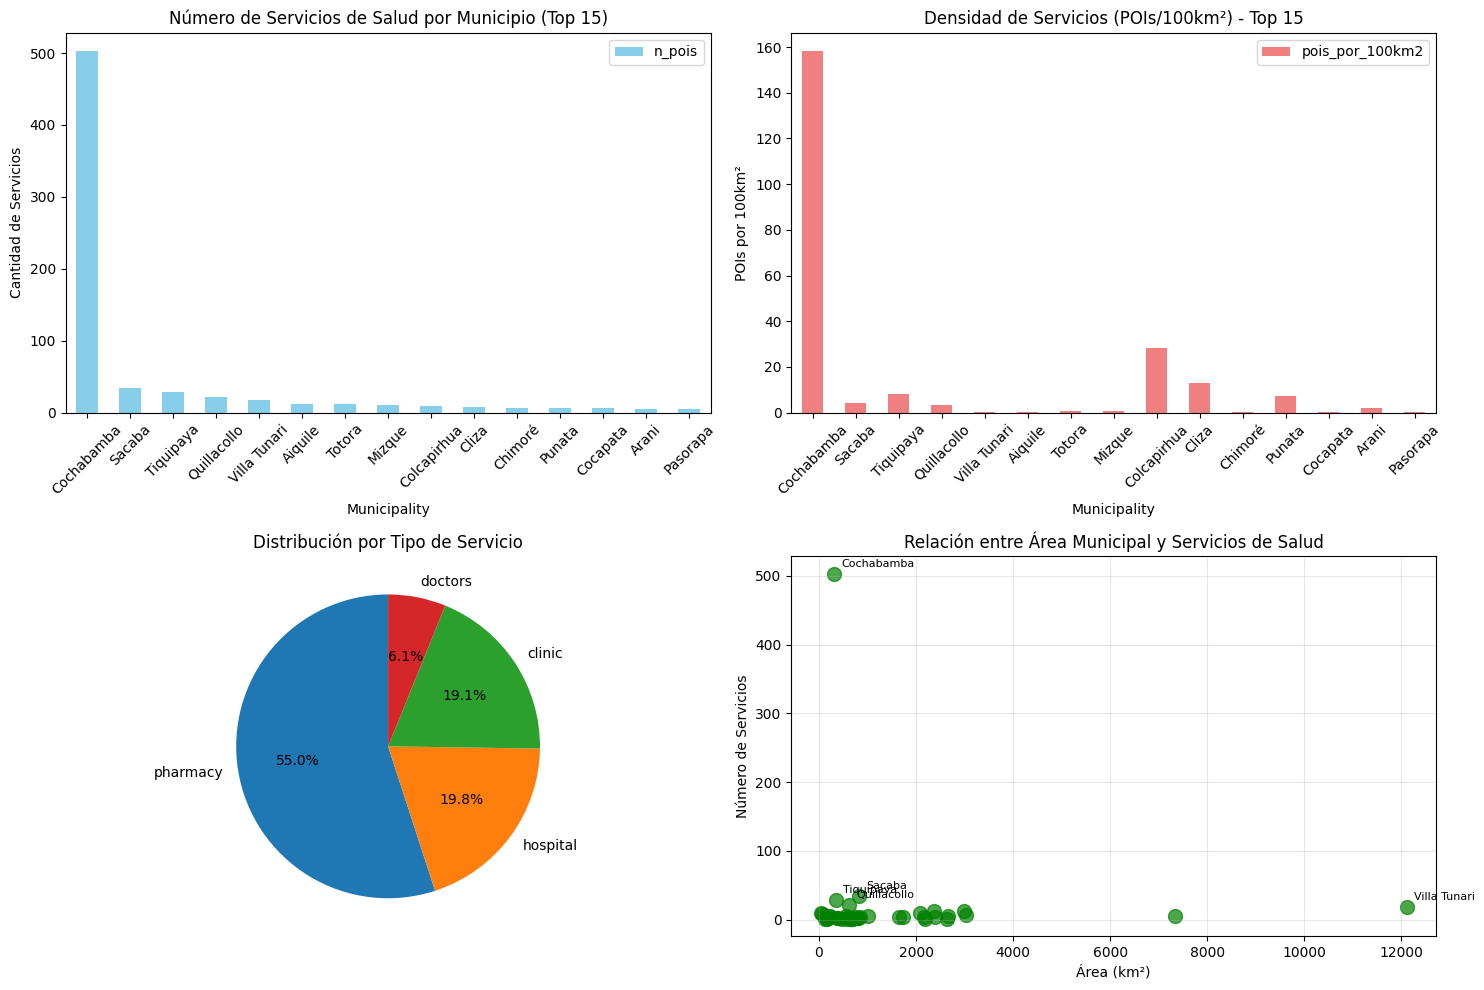

In [13]:
# Crear subplots para múltiples visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Solo municipios con servicios para los gráficos de barras
muni_con_servicios = muni_stats[muni_stats['n_pois'] > 0].nlargest(15, 'n_pois')

# 1. Gráfico de barras: Servicios por municipio (Top 15)
muni_con_servicios.plot(x='Municipality', y='n_pois', kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Número de Servicios de Salud por Municipio (Top 15)')
axes[0,0].set_ylabel('Cantidad de Servicios')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Gráfico de densidad (Top 15)
muni_con_servicios.plot(x='Municipality', y='pois_por_100km2', kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Densidad de Servicios (POIs/100km²) - Top 15')
axes[0,1].set_ylabel('POIs por 100km²')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Distribución por tipo de servicio (pie chart)
tipo_counts = pois_in['amenity'].value_counts()
axes[1,0].pie(tipo_counts.values, labels=tipo_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Distribución por Tipo de Servicio')

# 4. Comparación área vs servicios (solo municipios con servicios)
scatter_data = muni_stats[muni_stats['n_pois'] > 0]
axes[1,1].scatter(scatter_data['area_km2'], scatter_data['n_pois'], s=100, alpha=0.7, color='green')

# Anotar solo los municipios más importantes
top_5_servicios = scatter_data.nlargest(5, 'n_pois')
for i, row in top_5_servicios.iterrows():
    axes[1,1].annotate(row['Municipality'], 
                      (row['area_km2'], row['n_pois']), 
                      xytext=(5, 5), textcoords='offset points',
                      fontsize=8)

axes[1,1].set_xlabel('Área (km²)')
axes[1,1].set_ylabel('Número de Servicios')
axes[1,1].set_title('Relación entre Área Municipal y Servicios de Salud')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Conclusiones y Recomendaciones

### Hallazgos Principales:

1. **Concentración urbana extrema**: El municipio de Cochabamba concentra el 67.2% de los servicios de salud del departamento (503 de 749), reflejando una fuerte centralización urbana.

2. **Área metropolitana**: Los municipios del valle central (Cochabamba, Sacaba, Tiquipaya, Quillacollo) concentran el 78.8% de todos los servicios, evidenciando desigualdades territoriales significativas.

3. **Distribución territorial**:
   - **47 municipios** analizados en total
   - **40 municipios** (85%) tienen al menos 1 servicio
   - **7 municipios** (15%) sin servicios de salud registrados
   - **Rango**: 0-503 servicios por municipio

4. **Patrones geográficos claros**:
   - **Valle central**: Alta densidad de servicios
   - **Chapare**: Villa Tunari como centro regional
   - **Zonas rurales montañosas**: Acceso muy limitado

5. **Distribución por tipo**: Farmacias (55%), Hospitales (19.8%), Clínicas (19.1%), Consultorios (6.1%)

### Metodología Exitosa:

- **Datos completos**: 749 POIs asignados exitosamente a 47 municipios
- **Fuente local confiable**: Uso de archivo GeoJSON evitó dependencias de servicios web
- **Visualización efectiva**: Mapas por categorías más informativos que escalas continuas

### Recomendaciones:

1. **Política de descentralización**: Urgente necesidad de fortalecer servicios en municipios rurales
2. **Centros regionales**: Potenciar Villa Tunari y otros nodos como centros de referencia
3. **Análisis futuro**: Incluir análisis de accesibilidad considerando distancias y tiempos de viaje
4. **Actualización de datos**: Contribuir a la mejora de información en OpenStreetMap para análisis continuos

### Limitaciones:

- Dependencia de la completitud de datos en OpenStreetMap
- No considera capacidad, calidad o especialización de los servicios
- Análisis estático que no refleja flujos de pacientes entre municipios